** This notebook assumes ... **

1) Basic familiarity with gwsurrogate as covered in basics.ipynb 

2) You've downloaded a numerical relativity surrogate. To see all available surrogates, check the surrogate repository with the command "gws.catalog.list()"

In [1]:
### setup paths used throughout this notebook ###
import sys
path_to_gws = '/home/balzani57/Repo/GitRepos/Codes/gwsurrogate/'
sys.path.append(path_to_gws)

%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
import gwsurrogate as gws
import gwsurrogate.gwtools as gwtools

import tqdm

/home/balzani57/Repo/GitRepos/Codes/gwsurrogate/gwsurrogate/gwtools/gwtools.py:57: UserWarning: using non-LAL constants
  _warnings.warn("using non-LAL constants")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


In [2]:
### load the surrogate data ###
path_to_surrogate = path_to_gws+'surrogate_downloads/SpEC_q1_10_NoSpin_nu5thDegPoly_exclude_2_0.h5'
spec = gws.EvaluateSurrogate(path_to_surrogate, ell_m=[(2,2), (3,3)]) # load two m>0 modes only

loading surrogate mode... l2_m2
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l3_m3
>>> tmin, tmax, dt are depricated as of 11/23/2016.
('Surrogate interval', array([ 0.  ,  0.25]))
('Surrogate time grid', array([-2750. , -2749.9, -2749.8, ...,    99.8,    99.9,   100. ]))
Surrogate parameterization map from q to symmetric mass ratio nu
  
  Surrogates with this parameterization expect its user intput 
  to be the mass ratio q. 
  
  The surrogate will map q to the internal surrogate's 
  parameterization which is nu
  
  The surrogates training interval is quoted in symmetric mass ratio.
  


# Lesson 1: Simple evaluations

You have evaluated the (2,2) mode


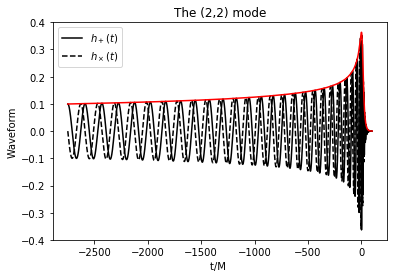

In [3]:
# Evaluate and plot the 2,2 mode. 
# By default, the modes are evaluated on the sphere, and negative modes are generated from 
# known relationships. So we need to set both options to false to get only the (2,2) mode.
modes, times, hp, hc = spec(q=1.7, ell=[2], m=[2], mode_sum=False, fake_neg_modes=False)
print('You have evaluated the (%i,%i) mode'%(modes[0][0],modes[0][1]))

gwtools.plot_pretty(times, [hp, hc],fignum=1)
plt.plot(times,gwtools.amp(hp+1j*hc),'r')
plt.title('The (%i,%i) mode'%(modes[0][0],modes[0][1]))
plt.xlabel('t/M ')
plt.show()

('Evaluated modes =', [(3, -3), (3, 3)])


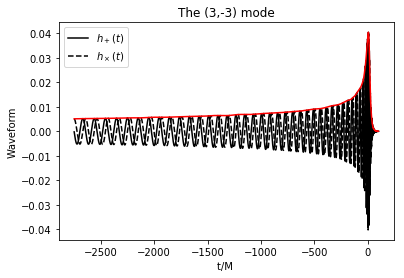

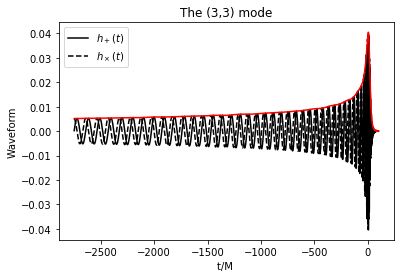

In [4]:
# generating both the (3,3) and (3,-3) modes is easy!
modes, times, hp, hc = spec(q=1.7, ell=[3], m=[3], mode_sum=False)
print("Evaluated modes =", modes)

gwtools.plot_pretty(times, [hp[:,0], hc[:,0]],fignum=2)
plt.plot(times,gwtools.amp(hp[:,0]+1j*hc[:,0]),'r')
plt.xlabel('t/M ')
plt.title('The (%i,%i) mode'%(modes[0][0],modes[0][1]))

gwtools.plot_pretty(times, [hp[:,1], hc[:,1]],fignum=3)
plt.plot(times,gwtools.amp(hp[:,1]+1j*hc[:,1]),'r')
plt.title('The (%i,%i) mode'%(modes[1][0],modes[1][1]))
plt.xlabel('t/M ')
plt.show()

In [5]:
# Trying to evaluate a mode which doesn't exist throws a warning
spec(q=1.7, ell=[3], m=[2], mode_sum=False, fake_neg_modes=False)

Warning: Your mode (ell,m) = (3,2) is not available!

# Lesson 2: Physical waveforms

In [6]:
# load all the modes except the 2,0 mode, which is excluded by default (See http://arxiv.org/abs/1502.07758 for why)
spec = gws.EvaluateSurrogate(path_to_surrogate)

loading surrogate mode... l2_m1
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l2_m2
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l3_m1
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l3_m2
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l3_m3
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l4_m2
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l4_m3
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l4_m4
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l5_m2
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l5_m3
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l5_m4
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l5_m5
>>> tmin, tmax, dt are depricated as of 11/2

In [7]:
# Evaluate the (2,2) mode for physical input values
M     = 115.0 # units of solar masses 
q     = 1.0
theta = np.pi/3.0
phi   = np.pi/3.0
dist  = 1.0 # units of megaparsecs
fmin  = 10.0 # units of hz

# The surrogate evaluation is NOT long enough to achieve a starting frequency of 10hz
modes,times,hp,hc = spec(M=M,q=q,dist=dist,theta=theta,phi=phi,ell=[2],m=[2],mode_sum=False,fake_neg_modes=False,f_low=fmin)

Warning: starting frequency is 10.5978590147

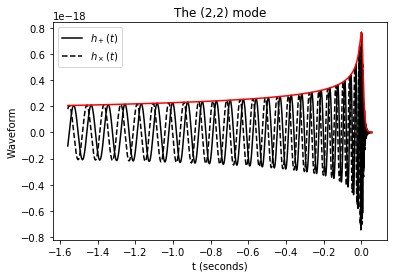

In [8]:
# We'll be safer with 15 hz 
fmin = 15
modes,times,hp,hc = spec(M=M,q=q,dist=dist,theta=theta,phi=phi,ell=[2],m=[2],mode_sum=False,fake_neg_modes=False,f_low=fmin)

gwtools.plot_pretty(times, [hp, hc])
plt.plot(times,gwtools.amp(hp+1j*hc),'r')
plt.xlabel('t (seconds)')
plt.title('The (%i,%i) mode'%(modes[0][0],modes[0][1]))
plt.show()

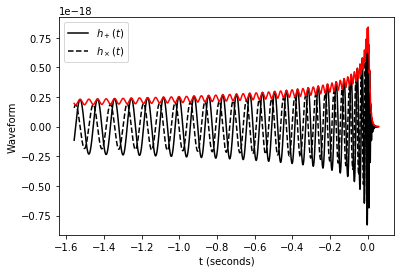

In [9]:
# Lets evaluate the (2,2) and (2,-2) at phi = theta = pi/3 on the sphere
times,hp,hc = spec(M=M,q=q,dist=dist,theta=theta,phi=phi,ell=[2],m=[2],f_low=fmin)

gwtools.plot_pretty(times, [hp, hc])
plt.plot(times,gwtools.amp(hp+1j*hc),'r')
plt.xlabel('t (seconds)')
plt.show()

# Lesson 3: Linear surrogates

Lessons 1 & 2 considered a nonlinear model: SpEC_q1_10_NoSpin_nu5thDegPoly_exclude_2_0.h5 prescribes a nonlinear relationship between the strain, h, and the data pieces (the amplitude and phase of each harmonic mode) that are modeled. 

We call a surrogate linear if $h_{\ell m}$ if it can be expressed as a linear combination of basis functions

$$h_{\ell m} (t;q) = \sum_{i=1}^n c_{\ell m}^n(q) e_{\ell m}^n(t)$$

Some applications, like the RapidPE pipeline, [benefit from using a linear surrogate model](http://iopscience.iop.org/article/10.1088/1361-6382/aa7649/meta). These surrogates are also typically faster to evaluate. 

Here we consider two "linearized" (an admittedly poor modifier) versions of the surrogate SpEC_q1_10_NoSpin_nu5thDegPoly_exclude_2_0.h5. We simply show these models agree with one another, as they should

In [10]:
# reload all modes of the original nonlinear surrogate model, including the (2,0)
path_to_surrogate = path_to_gws+'surrogate_downloads/SpEC_q1_10_NoSpin_nu5thDegPoly_exclude_2_0.h5'
sur = gws.EvaluateSurrogate(path_to_surrogate,excluded=None)

loading surrogate mode... l2_m0
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l2_m1
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l2_m2
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l3_m1
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l3_m2
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l3_m3
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l4_m2
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l4_m3
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l4_m4
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l5_m2
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l5_m3
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l5_m4
>>> tmin, tmax, dt are depricated as of 11/2

### A Linear, fast-spline surrogate using the default gwsurrogate interface

In [11]:
# load the linear, fast-spline surrogate model
path_to_surrogate = "/home/balzani57/Repo/GitRepos/Codes/gwsurrogate/surrogate_downloads/SpEC_q1_10_NoSpin_nu5thDegPoly_exclude_2_0_FastSplined_WithVandermonde.h5"
sur_lin = gws.EvaluateSurrogate(path_to_surrogate,excluded=None)

loading surrogate mode... l2_m0

>>> Warning: Guessing quadrature weights to be identical with 0.100000
Cannot load greedy points...OK
Cannot load eim points...OK
Special case: using fast tensor spline for real and imaginary parts instead of amp/phase
Loading fast tensor spline breakpoints
loading surrogate mode... l2_m1

>>> Warning: Guessing quadrature weights to be identical with 0.100000
Cannot load greedy points...OK
Cannot load eim points...OK
Special case: using fast tensor spline for real and imaginary parts instead of amp/phase
Loading fast tensor spline breakpoints
loading surrogate mode... l2_m2

>>> Warning: Guessing quadrature weights to be identical with 0.100000
Cannot load greedy points...OK
Cannot load eim points...OK
Special case: using fast tensor spline for real and imaginary parts instead of amp/phase
Loading fast tensor spline breakpoints
loading surrogate mode... l3_m1

>>> Warning: Guessing quadrature weights to be identical with 0.100000
Cannot load greedy poin

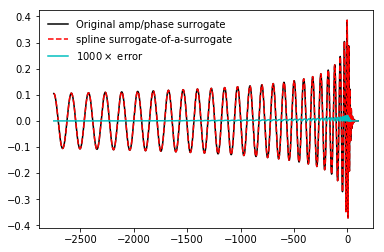

('evaluated (ell, m) modes =', [(2, 0), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3), (4, 2), (4, 3), (4, 4), (5, 2), (5, 3), (5, 4), (5, 5), (6, 3), (6, 4), (6, 5), (6, 6), (7, 5), (7, 6), (7, 7), (8, 6), (8, 7), (8, 8)])


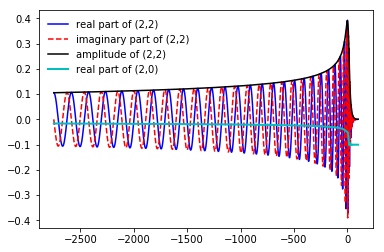

In [13]:
# check the original surrogate and linear "surrogate-of-a-surrogate" models agree
lm_modes, t, hreal_lin, himag_lin = sur_lin(1.2, mode_sum=False, fake_neg_modes=False)
lm_modes, t, hreal, himag = sur(q=1.2, mode_sum=False, fake_neg_modes=False)

plt.figure(1)
plt.plot(t, hreal[:, 2], 'k', label='Original amp/phase surrogate')
plt.plot(t, np.real(hreal_lin[:, 2]), 'r--', label='spline surrogate-of-a-surrogate')
plt.plot(t, (1000.0)* abs(hreal[:, 2] - np.real(hreal_lin[:, 2])), 'c', label=r'$1000 \times$ error')
plt.legend(frameon=False, loc='upper left')
plt.show()


# and make sure we get the (2, 0) mode as well
lm_modes, t, hreal, himag = sur_lin(1.0, mode_sum=False, fake_neg_modes=False)
print("evaluated (ell, m) modes =",lm_modes)

plt.figure(2)
h22 = hreal[:, 2] + 1.0j * himag[:, 2]
plt.plot(t, h22.real, 'b',label='real part of (2,2)')
plt.plot(t, h22.imag, 'r--',label='imaginary part of (2,2)')
plt.plot(t, np.abs(h22), 'k',label='amplitude of (2,2)')
plt.plot(t, hreal[:, 0], 'c', lw=2,label='real part of (2,0)')
plt.legend(frameon=False, loc='upper left')
plt.show()

100%|██████████| 150/150 [00:15<00:00,  9.53it/s]


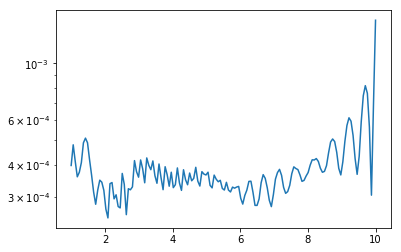

In [14]:
# now perform a more complete error analysis
nqtest = 150
qtest = np.linspace(1., 10., nqtest)

def many_h_evals(qvals):
    """evalutate the original surrogate at many mass ratio values"""
    h_evals = []
    for i in tqdm.trange(len(qvals)):
        q = qvals[i]
        _, t, hreal, himag = sur(q, mode_sum=False, fake_neg_modes=False)
        h_evals.append( hreal + 1.j*himag )
    return h_evals

def waveform_norm(h):
    return np.sqrt(np.sum(abs(h**2)))

def waveform_error(h1, h2):
    return waveform_norm(h1 - h2) / waveform_norm(h1)

def test_spline_surrogate(spline_surrogate, nqtest, h_evals):
    qtest = np.linspace(1., 10., nqtest)
    errs = []
    for i in tqdm.trange(len(qtest)):
        q = qtest[i]
        h = h_evals[i]
        lm_modes, t, hreal, himag = spline_surrogate(q, mode_sum=False, fake_neg_modes=False)
        h_spline = hreal + 1.j*himag
        #h_spline = np.array([spline_modes[k] for k in lm_modes])
        errs.append(waveform_error(h, h_spline))
    return np.array(errs)

h_evals = many_h_evals(qtest)

loaded_err = test_spline_surrogate(sur_lin, nqtest, h_evals)
plt.semilogy(qtest, loaded_err, label='error')

### Linear, fast-spline surrogate using a new gws interface

In [17]:
# FastTensorSplineSurrogate is a new feature
from gwsurrogate.new import surrogate 
loaded_surrogate = surrogate.FastTensorSplineSurrogate()

# ... and we load the linear (spline) surrogate in a different way
path_to_surrogate = '/home/balzani57/Repo/GitRepos/Codes/gwsurrogate/surrogate_downloads/'
loaded_surrogate.load(path_to_surrogate+"SpEC_q1_10_NoSpin_nu5thDegPoly_exclude_2_0_FastSplined_WithVandermonde_NewInterface.h5")

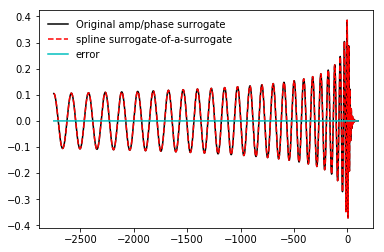

In [18]:
# check the original and linear "surrogate-of-a-surrogate" models agree
h_modes = loaded_surrogate([1.2])
lm_modes, t, hreal, himag = sur(q=1.2, mode_sum=False, fake_neg_modes=False)

plt.plot(t, hreal[:, 2], 'k', label='Original amp/phase surrogate')
plt.plot(t, np.real(h_modes[2, 2]), 'r--', label='spline surrogate-of-a-surrogate')
plt.plot(t, abs(hreal[:, 2] - np.real(h_modes[2, 2])), 'c', label='error')
plt.legend(frameon=False, loc='upper left')
plt.show()

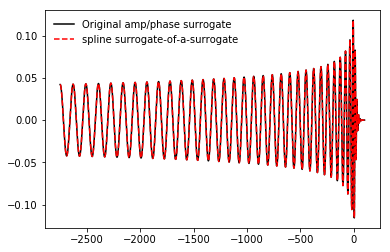

3.00335928002e-12
1.82618058182e-11


In [19]:
## Compare the linear surrogate using new and original interfaces -- These should be EXACTLY identical 
h_modes = loaded_surrogate([10.0])

_, t, hreal, himag = sur_lin(q=10.0, mode_sum=False, fake_neg_modes=False)
h = hreal + 1.j*himag

plt.plot(t, hreal[:, 2], 'k', label='Original amp/phase surrogate')
plt.plot(t, np.real(h_modes[2, 2]), 'r--', label='spline surrogate-of-a-surrogate')
#plt.plot(t, abs(hreal[:, 2] - np.real(h_modes[2, 2])), 'c', label='error')
plt.legend(frameon=False, loc='upper left')
plt.show()

print np.max(abs(hreal[:, 2] - np.real(h_modes[2, 2])))

h_modes = np.array([h_modes[k] for k in lm_modes])

print waveform_error(h_modes, h.T)

100%|██████████| 100/100 [00:12<00:00,  7.81it/s]


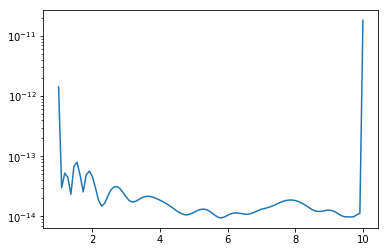

In [20]:
# ...and a more complete error analysis
errs = []

nqtest = 100
qtest = np.linspace(1., 10., nqtest)

for i in tqdm.trange(len(qtest)):
    q = qtest[i]

    h_modes = loaded_surrogate([q])

    _, t, hreal, himag = sur_lin(q=q, mode_sum=False, fake_neg_modes=False)
    h = hreal + 1.j*himag

    h_spline = np.array([h_modes[k] for k in lm_modes])
    errs.append(waveform_error(h_spline, h.T))
    
errs = np.array( errs )
plt.semilogy(qtest, errs, label='error')
# ... Why aren't the errors exactly zero? Its probably due to nudging
# where the end point parameters are not truely identical
